# ***What is Checkpoint id in langgraph Thrade or Messages History***


### Overview

- In LangGraph, a "checkpoint ID" is an identifier that distinguishes a specific checkpoint within a thread. Think of it as a unique snapshot of the graph's state at a particular point in time during its execution, tagged with a specific thread ID. 
Here's a more detailed explanation:
- Thread:
A thread in LangGraph represents a unique session or conversation associated with a graph execution. 
- Checkpoint:
A checkpoint is a snapshot of the graph's state at a particular super-step (a point where the graph executes a batch of nodes). 
- Checkpoint ID:
Each checkpoint within a thread is given a unique ID, allowing you to refer to that specific state snapshot. This ID helps you navigate the history of the thread and access the graph's state at different points. 
- In essence, the checkpoint ID is like a key that unlocks a specific moment in the graph's execution history, allowing you to retrieve the state of the graph as it was at that particular point in time within a given thread. 

In [40]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [41]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

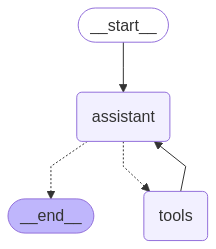

In [42]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [43]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 3 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ah9v)
 Call ID: call_ah9v
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## Browsing History
- Hare we can use `get_state` to look at the current state of our graph, given the `thread_id`

In [44]:
graph.get_state(
    thread
)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ah9v', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039331423, 'prompt_time': 0.011659628, 'queue_time': 0.046041832000000005, 'total_time': 0.050991051}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5fefb543-7934-4644-b2c8-2351f331efbd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_ah9v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='d77dc111-7a8c-419

In [45]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ah9v', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039331423, 'prompt_time': 0.011659628, 'queue_time': 0.046041832000000005, 'total_time': 0.050991051}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5fefb543-7934-4644-b2c8-2351f331efbd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_ah9v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='d77dc111-7a8c-419

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [46]:
all_states = [s for s in graph.get_state_history(thread)]

In [47]:
len(all_states)

5

In [48]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ah9v', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039331423, 'prompt_time': 0.011659628, 'queue_time': 0.046041832000000005, 'total_time': 0.050991051}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5fefb543-7934-4644-b2c8-2351f331efbd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_ah9v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='d77dc111-7a8c-419

In [49]:
all_states[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c96d-cab7-6227-bfff-eb558ead844b'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={})}}, 'step': -1, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T05:31:30.742531+00:00', parent_config=None, tasks=(PregelTask(id='d2eefaa2-ed1b-aa5e-c4d9-a3fb6b9274b9', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')}),), interrupts=())

In [50]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c96d-cab7-6228-8000-a60c55168b31'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T05:31:30.742531+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c96d-cab7-6227-bfff-eb558ead844b'}}, tasks=(PregelTask(id='5be54d6a-b277-b823-e144-3a1dd2c87914', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ah9v', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## ***Replaying***
- We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [51]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c96d-cab7-6228-8000-a60c55168b31'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T05:31:30.742531+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c96d-cab7-6227-bfff-eb558ead844b'}}, tasks=(PregelTask(id='5be54d6a-b277-b823-e144-3a1dd2c87914', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ah9v', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 

In [52]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')]}

In [53]:
to_replay.next

('assistant',)

In [54]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c96d-cab7-6228-8000-a60c55168b31'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [55]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pppv)
 Call ID: call_pppv
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## **Forking**

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [56]:
to_fork = all_states[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')]

In [57]:
## and this step config like the checkpoint id is

to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c96d-cab7-6228-8000-a60c55168b31'}}

### Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [58]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [HumanMessage(content="multiply 5 and 4",
                                  id = to_fork.values['messages'][0].id)]
    },
)

In [59]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c96d-d89a-6308-8001-98ff5c3c30ee'}}

### This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [60]:
all_states = [state for state in graph.get_state_history(thread)]

In [61]:
all_states[0].values['messages']

[HumanMessage(content='multiply 5 and 4', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532')]

In [62]:
all_states[0].next

('assistant',)

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [63]:
for event in graph.stream(None, fork_config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 5 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bav7)
 Call ID: call_bav7
  Args:
    a: 5
    b: 4
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

The result of multiplying 5 and 4 is 20.


In [64]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='multiply 5 and 4', additional_kwargs={}, response_metadata={}, id='cd096072-a6dc-40ee-acc2-a43214a03532'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bav7', 'function': {'arguments': '{"a": 5, "b": 4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039264892, 'prompt_time': 0.013933728, 'queue_time': 0.061256462000000005, 'total_time': 0.05319862}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--54aa5cc9-e163-4928-a293-d151791c3d50-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 4}, 'id': 'call_bav7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='20', name='multiply', id='02d645ac-ddef-493

# **Time travel with LangGraph API**

In [65]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

## *Re-playing*

In [66]:
initial_input = {"messages": HumanMessage(content="Multiply 4 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_tp6t', 'function': {'arguments': '{"a": 4, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 20, 'prompt_tokens': 352, 'total_tokens': 372, 'completion_time': 0.042205556, 'prompt_time': 0.011154747, 'queue_time': 0.048392053, 'total_time': 0.053360303}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--11e77096-d7f0-42bd-a16f-5ba8f5c6aa6c-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 4, 'b': 3}, 'id': 'call_tp6t', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 352, 'output_tokens': 20, 'total_tokens': 372}}
--------------------Tools Node--------------------
{'content': '12', 'additional_kwargs': {}, 'respon

In [67]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 4 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'dcfe423e-9529-4d52-b8e5-a611cbab9b37',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '3cd218a9-0451-0208-6569-04d4fff6087a',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_tp6t',
         'function': {'arguments': '{"a": 4, "b": 3}', 'name': 'multiply'},
         'type': 'function'}]},
      'response_metadata': {'token_usage': {'completion_tokens': 20,
        'prompt_tokens': 352,
        'total_tokens': 372,
        'completion_time': 0.042205556,
        'prompt_time': 0.011154747,
        'queue_time': 0.048392053,
        'total_time': 0.053360303},
       'model_name': 'meta-llama/llama-4-scout-17b-16

In [68]:
# stream mode is update
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f02c96d-f7c9-61f7-9937-dddbad817581', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 4 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'dcfe423e-9529-4d52-b8e5-a611cbab9b37', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 4 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'dcfe423e-9529-4d52-b8e5-a611cbab9b37', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_wda0', 'function': {'arguments': '{"a": 4, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 20, 'prompt_tokens': 352, 'total_tokens': 372, 'completion_time': 0.039386973, 'prompt_time': 0.016044396, 'queue_time': 0.057325614, 'total_time': 0.055431369}, 'model_name': 'meta-llama/llama-4-scout-1

In [69]:
## steaming in update mode

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_pgeq', 'function': {'arguments': '{"a": 4, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 20, 'prompt_tokens': 352, 'total_tokens': 372, 'completion_time': 0.039320804, 'prompt_time': 0.012672952, 'queue_time': 0.045111578, 'total_time': 0.051993756}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--211c88de-a961-44ed-ab58-47ad8139de79-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 4, 'b': 3}, 'id': 'call_pgeq', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 352, 'output_tokens': 20, 'total_tokens': 372}}
--------------------Tools Node--------------------
{'content': '12', 'additional_kwargs': {}, 'respon

# ***Forking***

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [70]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_d7be', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 20, 'prompt_tokens': 352, 'total_tokens': 372, 'completion_time': 0.039347762, 'prompt_time': 0.011261, 'queue_time': 0.04640098, 'total_time': 0.050608762}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--b7ce52f6-c253-4114-a14b-fcf9f061d3da-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_d7be', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 352, 'output_tokens': 20, 'total_tokens': 372}}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_me

#### above cell error for the model make this mistake

In [71]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '98f8fd52-46cf-4439-bcce-46d927dd89d0',
   'example': False},
  {'content': '',
   'additional_kwargs': {'tool_calls': [{'id': 'call_d7be',
      'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'},
      'type': 'function'}]},
   'response_metadata': {'token_usage': {'completion_tokens': 20,
     'prompt_tokens': 352,
     'total_tokens': 372,
     'completion_time': 0.039347762,
     'prompt_time': 0.011261,
     'queue_time': 0.04640098,
     'total_time': 0.050608762},
    'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct',
    'system_fingerprint': 'fp_37da608fc1',
    'finish_reason': 'tool_calls',
    'logprobs': None},
   'type': 'ai',
   'name': None,
   'id': 'run--b7ce52f6-c253-4114-a14b-fcf9f061d3da-0',
   'example': False,
   'tool_calls': [{'name': 'multiply',
     'args': {'a': 2, 'b': 3},
     'id': 'cal

In [72]:
to_fork['values']['messages'][0]['id']

'98f8fd52-46cf-4439-bcce-46d927dd89d0'

In [73]:
to_fork['next']

['tools']

In [74]:
to_fork['parent_checkpoint']

{'checkpoint_id': '1f02c96e-3296-6552-8010-4973798ae2d0',
 'thread_id': 'e4f1dbdc-da65-43e9-8cac-a9d942cf145d',
 'checkpoint_ns': ''}

In [75]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [76]:
forked_config

{'checkpoint': {'thread_id': 'e4f1dbdc-da65-43e9-8cac-a9d942cf145d',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c96e-4516-6175-8012-e1bae61a8c9a'},
 'configurable': {'thread_id': 'e4f1dbdc-da65-43e9-8cac-a9d942cf145d',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c96e-4516-6175-8012-e1bae61a8c9a'},
 'checkpoint_id': '1f02c96e-4516-6175-8012-e1bae61a8c9a'}

In [77]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '98f8fd52-46cf-4439-bcce-46d927dd89d0',
    'example': False},
   {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'call_d7be',
       'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'},
       'type': 'function'}]},
    'response_metadata': {'token_usage': {'completion_tokens': 20,
      'prompt_tokens': 352,
      'total_tokens': 372,
      'completion_time': 0.039347762,
      'prompt_time': 0.011261,
      'queue_time': 0.04640098,
      'total_time': 0.050608762},
     'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct',
     'system_fingerprint': 'fp_37da608fc1',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'run--b7ce52f6-c253-4114-a14b-fcf9f061d3da-0',
    'example': False,
    'tool_calls': [{'name': 'multiply',
      'ar

In [78]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '9.0', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'divide', 'id': '2837dfb2-7a52-4a9f-8661-221e15eb5bd3', 'tool_call_id': 'call_srk5', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_7ncg', 'function': {'arguments': '{"a":9, "b":9}', 'name': 'add'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 613, 'total_tokens': 630, 'completion_time': 0.037910179, 'prompt_time': 0.028719766, 'queue_time': 0.07796789300000001, 'total_time': 0.066629945}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--510d2e8f-894d-4ed1-8464-397d114de931-0', 'example': False, 'tool_calls': [{'name': 'add', 'args': {'a': 

#### above cell mistake for the agent code and model error its fixed later but its conceptually correct